In [1]:
import numpy as np
import datetime
import matplotlib.pylab as plt
from dataloader import DataLoader
from dataset import DataSet
import tensorflow as tf
from tensorflow.contrib.learn.python.learn.datasets import base
from tensorflow.python.framework import dtypes

In [2]:
# 注意tensorflow中labels组织成one_hot类型
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

In [3]:
def read_data_sets(train_dir,dtype=dtypes.float32):
    dl = DataLoader(train_dir)
    train_img,train_labels = dl.get_data(kind='train')
    test_img,test_labels = dl.get_data(kind='t10k')
    
    #将处理好的labels数据转换成one_hot类型
    train_labels = dense_to_one_hot(train_labels,10)
    test_labels = dense_to_one_hot(test_labels,10)
    
    options = dict(dtype = dtype)
    train = DataSet(train_img, train_labels,**options)
    test = DataSet(test_img, test_labels, **options)
    
    return base.Datasets(train = train, validation=None, test = test)

In [4]:
def show_images(Dataset,n):
    _, plts = plt.subplots(1,n,figsize=(15,15))
    for i in range(n):
        plts[i].imshow(Dataset.images[i].reshape((28,28)))
        plts[i].axes.get_xaxis().set_visible(False)
        plts[i].axes.get_yaxis().set_visible(False)
    plt.show()

In [5]:
def show_labels(Dataset, n):
    return Dataset.labels[0:n]

In [6]:
mnist = read_data_sets('~/.datasets/MNIST/')

### Model-LeNet5
#### 因为目前Mnist大小为28x28，所以对应LeNet-5中的卷积层进行修改，卷积核个数，大小，padding方式等
#### LeNet-5 中使用的激活函数为sigmod， 这里用了relu， 
#### LeNet-5 中没有dropout，这里使用了dropout
#### LeNet-5 最后使用MLP，这里最后分类使用了softmax

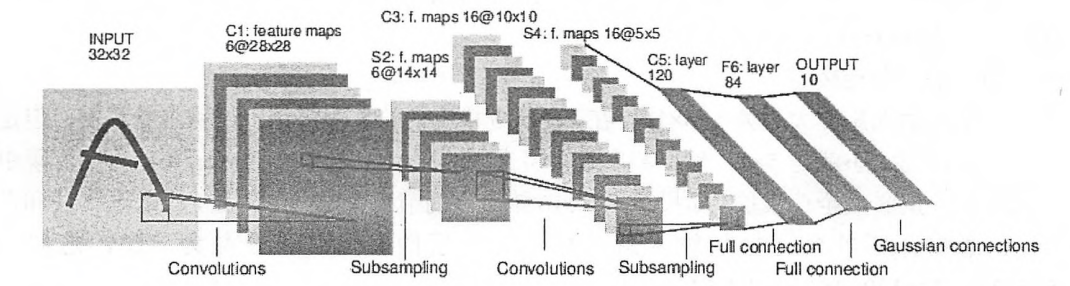

In [7]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1,shape = shape)
    return tf.Variable(initial)

def conv2d(x,W):
    return tf.nn.conv2d(x,W,strides=[1,1,1,1], padding="SAME")
#“SAME”“VALID”，“SAME”可以取到边缘特征，“VALID”取不到边缘特征
#定义输入矩阵 W x W
#filter 卷积核 F x F
#stride 步长 s
#“VALID” 卷积后输出尺寸为 new_height = new_weight = (W - F + 1)/s
#"SAME" 卷积后输出尺寸为 new_height = new_weight = W/s
def max_pool_2x2(x):
    return tf.nn.max_pool(x,ksize=[1,2,2,1],strides=[1,2,2,1],padding="SAME")

In [8]:
x = tf.placeholder(tf.float32,[None, 784])
y_ = tf.placeholder(tf.float32,[None, 10])
x_image = tf.reshape(x,[-1,28,28,1]) #将x从 1x784 一维向量变成 28x28 的二维向量；-1 表示样本数量不变,1表示一个通道

In [9]:
#layer1
#输入为28x28 输出为28x28x32一幅图片变成32个
W_conv1 = weight_variable([5,5,1,32])#初始化卷积操作，卷积核5x5， 通道是1，卷积核数量32
b_conv1 = bias_variable([32])
conv1 = conv2d(x_image,W_conv1) + b_conv1
h_conv1 = tf.nn.relu(conv1)

In [10]:
#layer2
#输入为28x28 输出为14x14
h_pool1 = max_pool_2x2(h_conv1)

In [11]:
#layer3
W_conv2 = weight_variable([5,5,32,64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

In [12]:
#layer4
h_pool2 = max_pool_2x2(h_conv2)
print h_pool2.shape

(?, 7, 7, 64)


In [13]:
#layer5
#第五层LeNet-5是一个卷积层因为卷积核5x5，此时输入也是5x5， 所以这是一个全连接层
W_fc1 = weight_variable([7*7 *64, 1024])
b_fc1 = bias_variable([1024])
h_pool2_flat = tf.reshape(h_pool2,[-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
print h_fc1

Tensor("Relu_2:0", shape=(?, 1024), dtype=float32)


In [14]:
#layer6
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([1024 ,10])
b_fc2 = bias_variable([10])
h_fc2 = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

In [15]:
#layer7
#LeNet-5这里；是一个NLP，这用的是一个softmax
y_conv = tf.nn.softmax(h_fc2)

In [16]:
#优化器,
#尝试不同的优化器发现区别很大，有的几乎就不会收敛，精度很差，不同优化器需要仔细看一下？
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_*tf.log(y_conv), reduction_indices=[1]))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

In [17]:
#sess
sess = tf.InteractiveSession()

In [18]:
#accuracy
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

In [19]:
#init
tf.global_variables_initializer().run()

In [20]:
for i in range(2000):
    batch = mnist.train.next_batch(50)
    if i%100 == 0:
        train_accuracy = accuracy.eval(feed_dict = {x:batch[0], y_:batch[1], keep_prob: 1})
        print "step %d, training accuracy %g" %(i, train_accuracy)
    train_step.run(feed_dict = {x:batch[0], y_:batch[1], keep_prob:0.5})

step 0, training accuracy 0.1
step 100, training accuracy 0.84
step 200, training accuracy 0.84
step 300, training accuracy 0.94
step 400, training accuracy 0.92
step 500, training accuracy 0.96
step 600, training accuracy 0.96
step 700, training accuracy 0.96
step 800, training accuracy 0.96
step 900, training accuracy 0.98
step 1000, training accuracy 0.96
step 1100, training accuracy 1
step 1200, training accuracy 0.92
step 1300, training accuracy 0.98
step 1400, training accuracy 0.96
step 1500, training accuracy 0.96
step 1600, training accuracy 0.98
step 1700, training accuracy 1
step 1800, training accuracy 0.98
step 1900, training accuracy 1


In [21]:
print ("test accuracy %g" % accuracy.eval(feed_dict = {x:mnist.test.images, y_:mnist.test.labels, keep_prob: 1.0}))

test accuracy 0.9766
